# Box-Cox Test for Linerarity

In [27]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import train_test_split
import itertools
import random
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy import stats
import numpy as np

In [28]:
#df_All = pd.read_csv(r"C:\Users\saust\OneDrive - Sasol\1 Project rC4\Jupyter Notebooks\Report 10-20-23 No Fluff\df_All_Avg.csv")

df_All_1o2 = pd.read_csv('3 Feature Selection/contData_all_Avg - 1o2.csv')
df_All_1o2 = pd.read_csv('3 Feature Selection/contData_all_Avg - 2o2.csv')

#df_All = pd.read_csv(r"C:\Users\saust\OneDrive\Desktop\CodeSpace DLs\102423\Project rC4\3 Final Machine Butanol\df_CDCA6.csv")


In [29]:
# Concatenate (union) the dataframes
df_All = pd.concat([df_All_1o2, df_All_1o2], ignore_index=True)

print(df_All.head())

    425 %Al  Butanol   Decanol    Ethanol   Hexanol   Octanol  AYC55580  \
0  6.466835    8.950  3.271667  29.233325  5.862082  5.912500  9.708929   
1  6.479165    8.750  3.261668  29.233325  5.832917  5.870832  9.647859   
2  6.491500    8.525  3.310000  28.950000  5.767500  5.790000  9.592980   
3  6.503835    8.275  3.416667  28.383325  5.665832  5.670000  9.572995   
4  6.516165    8.025  3.523332  27.816675  5.564167  5.550000  9.586615   

    DI55102   DI55152   DI55580     FC42428     FC52018    FC55003   FC55009  \
0  1.016935  0.974092  0.991364  35877.8500  40100.8500  5104.3775  4.327409   
1  1.017048  0.973535  0.991012  35918.5000  39930.9125  5044.2400  4.164241   
2  1.017505  0.973474  0.990783  35846.3625  39750.2750  5017.0425  3.969549   
3  1.017742  0.974004  0.990838  35773.5750  39566.3375  5044.1475  3.773128   
4  1.017679  0.974445  0.991013  35957.7750  39322.9000  5032.6700  3.599091   

      FC55102     FC55152     FC55552     FC55555     FC55569     FC

In [30]:
# Set max columns to display
pd.set_option('display.max_columns', None)

In [31]:
# df_All = df_All[df_All['Date'] > '2022-06-15 00:00:00']

In [32]:
# List of columns to exclude to run XGboost feature selection
exclude_columns = ['Octanol', 'Hexanol',
       'Ethanol', 'Decanol',
       
       'TI52014', 'TI55013', 'TI55014', 'TI55015', 'TI55016', 'TI55017', 'TI55021', 'TI55023',
       'TC52015', 'FC52018', 'II52554', 'TI40050', 'VI52558B'

       # 'FC55102', 'FC55152', 'LC55557', 'LC55568', 'TC55555',

       # '425 SAO Al', 'FFC55553', 'LC52572', 'LC90366',

       # 'FC42428', 'LC55553',

       # 'FC55009'
                   ]

# Create a new DataFrame without the excluded columnsd
df_All = df_All.drop(columns=exclude_columns)

In [33]:
df_All.columns

Index(['425 %Al', 'Butanol', 'AYC55580', 'DI55102', 'DI55152', 'DI55580',
       'FC42428', 'FC55003', 'FC55009', 'FC55102', 'FC55152', 'FC55552',
       'FC55555', 'FC55569', 'FC55576', 'FFC55553', 'FFC55555', 'FYC55553',
       'LC52572', 'LC55553', 'LC55555', 'LC55557', 'LC55568', 'LC90366',
       'LC90368', 'PI55004', 'PI55020', 'PI55560', 'TC55552', 'TC55553',
       'TC55555', 'TC55566'],
      dtype='object')

In [34]:
# Initialize DataFrame for Yeo-Johnson transformed data
df_yeojohnson = pd.DataFrame()

# Applying Yeo-Johnson transformation to each column
for column in df_All.columns:
    # Apply the Yeo-Johnson transformation
    transformed_data, _ = stats.yeojohnson(df_All[column])
    df_yeojohnson[column] = transformed_data

# The transformed DataFrame
print("Yeo-Johnson Transformed DataFrame:")
print(df_yeojohnson)

Yeo-Johnson Transformed DataFrame:
        425 %Al   Butanol   AYC55580     DI55102   DI55152   DI55580  \
0      8.160329  1.560865  11.540845  182.074610  0.182080  1.539487   
1      8.177788  1.551981  11.462390  182.184501  0.182073  1.538741   
2      8.195260  1.541686  11.391930  182.632011  0.182072  1.538257   
3      8.212736  1.529851  11.366280  182.864718  0.182079  1.538373   
4      8.230211  1.517574  11.383760  182.802229  0.182085  1.538744   
...         ...       ...        ...         ...       ...       ...   
49235  8.107535  0.695673   2.276862   51.512970  0.182063  1.397364   
49236  8.105357  0.676301   2.318328   51.513009  0.182066  1.397880   
49237  8.103185  0.656227   2.350060   51.513009  0.182069  1.398231   
49238  8.101014  0.640840   2.323199   51.513009  0.182066  1.398166   
49239  8.098836  0.630553   2.328340   51.513009  0.182066  1.398656   

            FC42428      FC55003     FC55009       FC55102       FC55152  \
0      6.980983e+19  570

In [24]:
# Initialize DataFrames for Box-Cox transformed data and data with negatives or zeros
df_boxcox = pd.DataFrame()
df_nonpositive = pd.DataFrame()

# Applying Box-Cox transformation or separating columns with negatives or zeros
for column in df_All.columns:
    if np.all(df_All[column] > 0):
        # Apply the Box-Cox transformation
        transformed_data, _ = stats.boxcox(df_All[column])
        df_boxcox[column] = transformed_data
    else:
        # Move column to the DataFrame for nonpositive values
        df_nonpositive[column] = df_All[column]

# Display or further process the DataFrames
print("Box-Cox Transformed DataFrame:")
print(df_boxcox)
print("\nDataFrame with Negative or Zero Values:")
print(df_nonpositive)

Box-Cox Transformed DataFrame:
        425 %Al   Butanol   DI55102   DI55152   DI55580       FC42428  \
0      6.696842  1.817737  0.017601 -0.027011 -0.008616  6.971552e+19   
1      6.713630  1.802353  0.017723 -0.027617 -0.008968  7.007167e+19   
2      6.730429  1.784542  0.018217 -0.027683 -0.009195  6.944061e+19   
3      6.747235  1.764093  0.018474 -0.027107 -0.009140  6.880836e+19   
4      6.764038  1.742904  0.018405 -0.026628 -0.008966  7.041711e+19   
...         ...       ...       ...       ...       ...           ...   
49235  6.646082  0.201972 -0.129766 -0.028372 -0.075500  2.300196e+19   
49236  6.643988  0.156235 -0.129766 -0.028161 -0.075257  2.305109e+19   
49237  6.641900  0.107816 -0.129766 -0.027950 -0.075092  2.301354e+19   
49238  6.639813  0.069947 -0.129766 -0.028133 -0.075123  2.297194e+19   
49239  6.637718  0.044243 -0.129766 -0.028153 -0.074892  2.298489e+19   

           FC55003     FC55009       FC55102       FC55152       FC55552  \
0      5700.0607

/home/codespace/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:935: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/codespace/.local/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2488: RuntimeWarning: invalid value encountered in scalar subtract
  tmp1 = (x - w) * (fx - fv)
/home/codespace/.local/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2489: RuntimeWarning: invalid value encountered in scalar subtract
  tmp2 = (x - v) * (fx - fw)


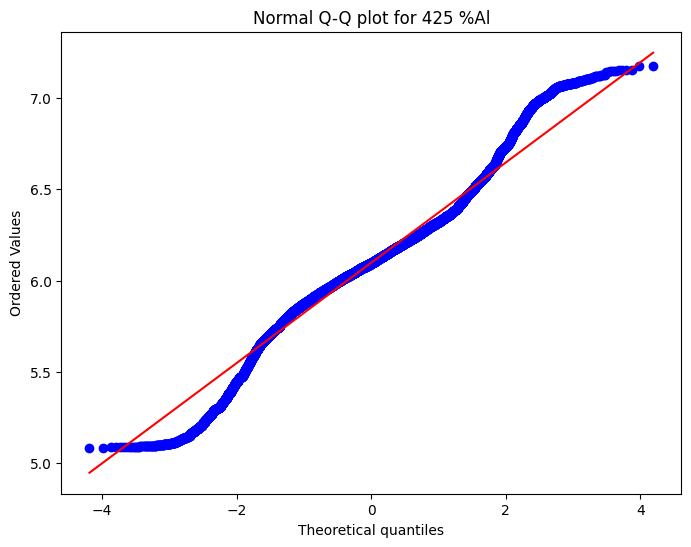

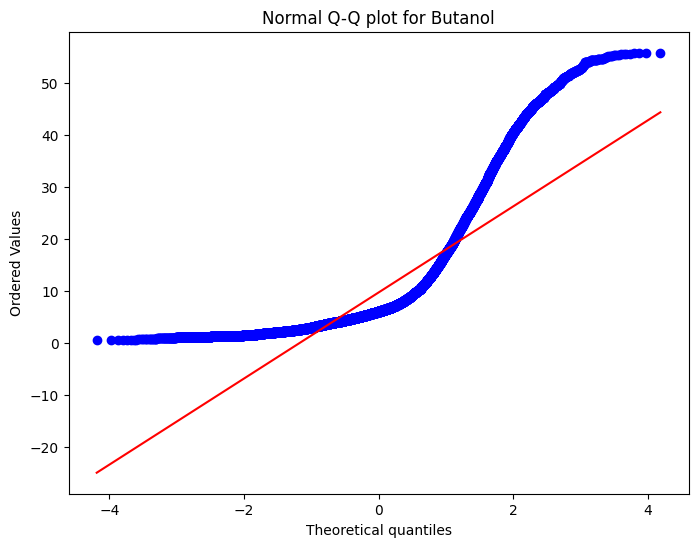

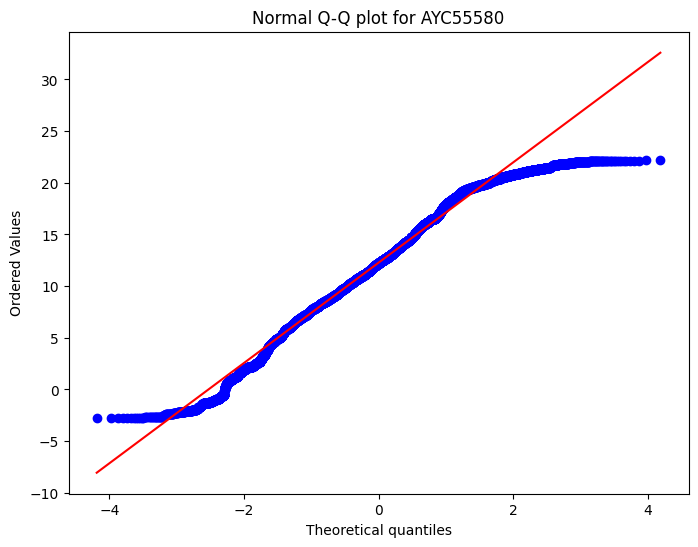

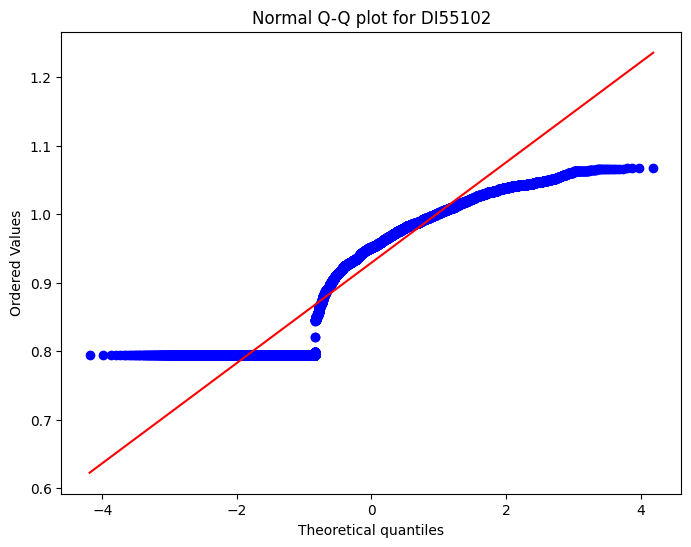

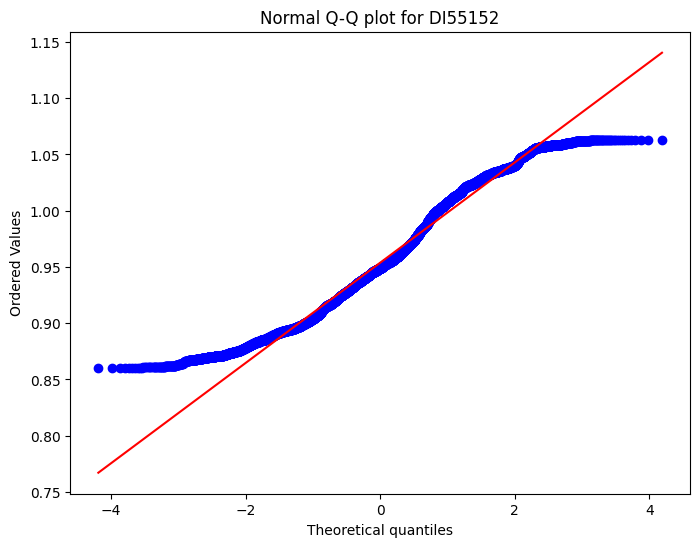

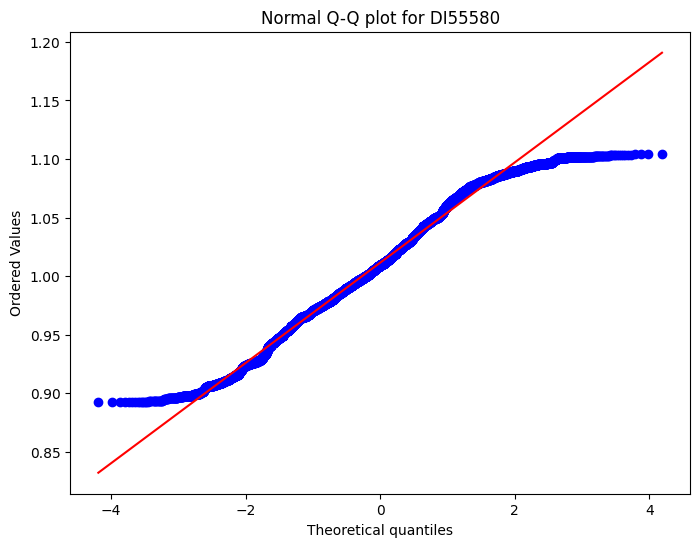

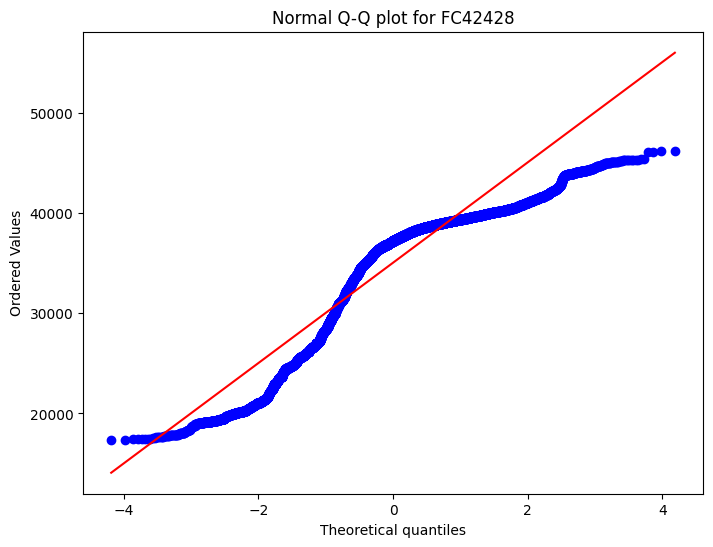

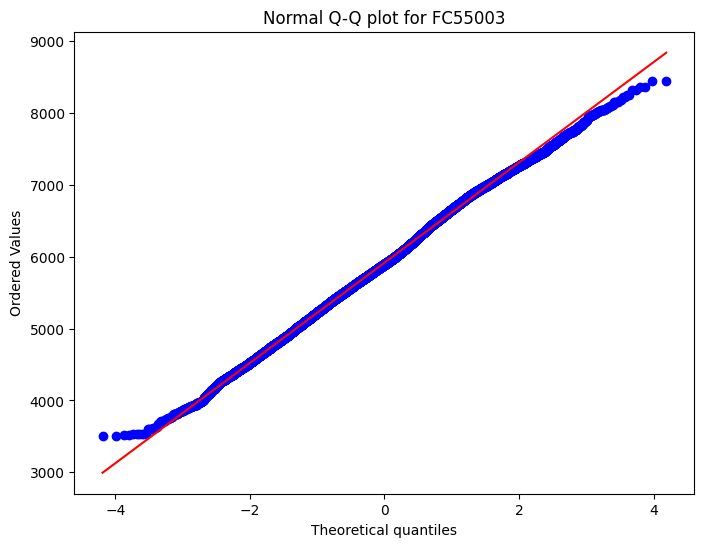

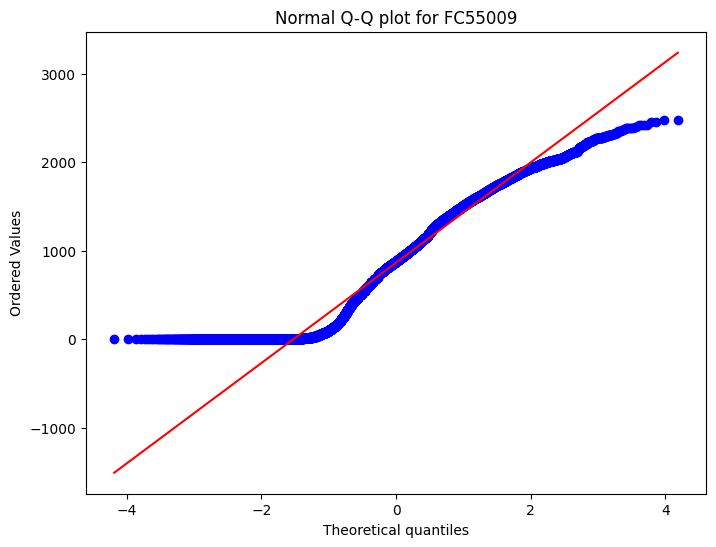

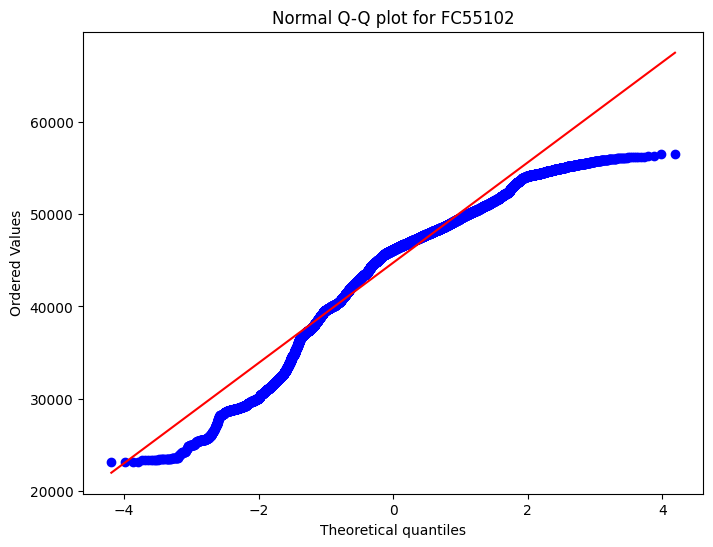

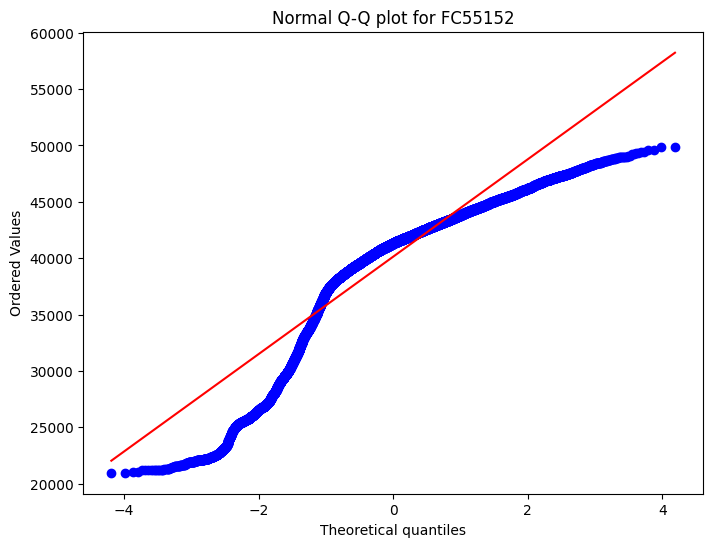

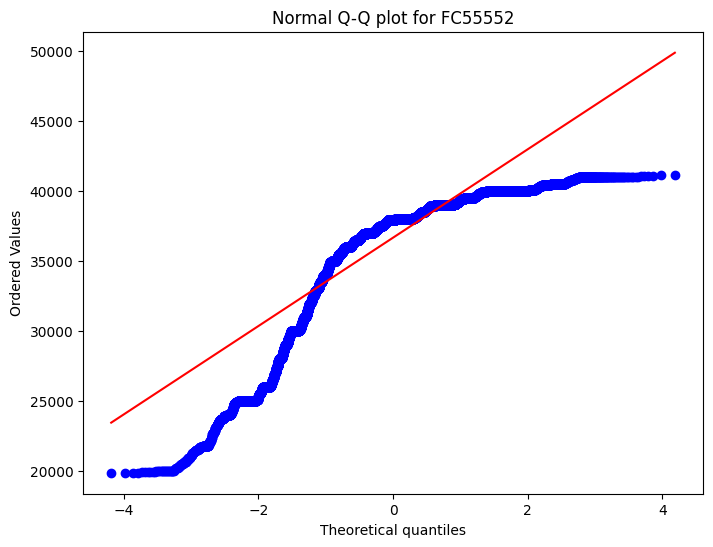

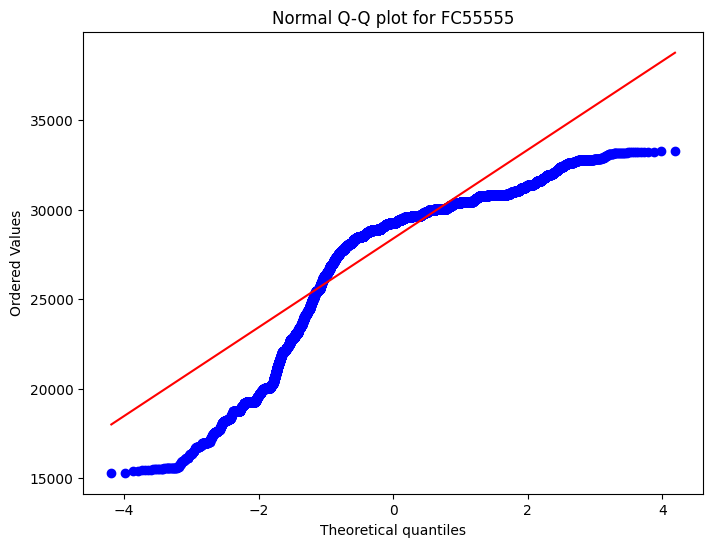

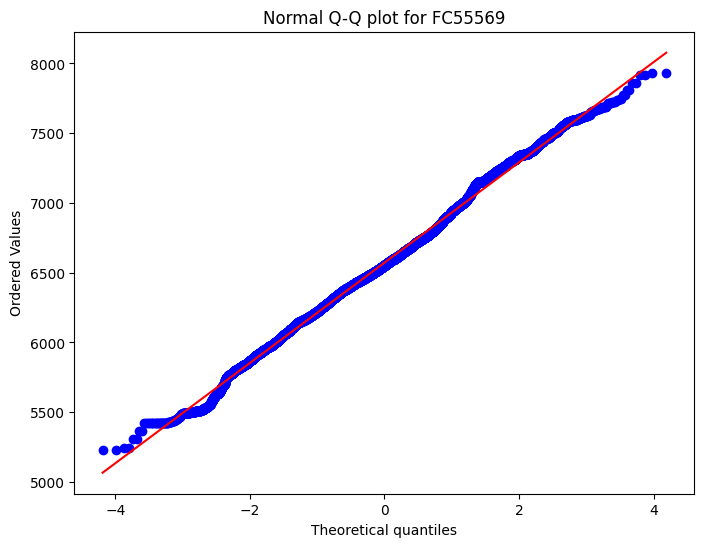

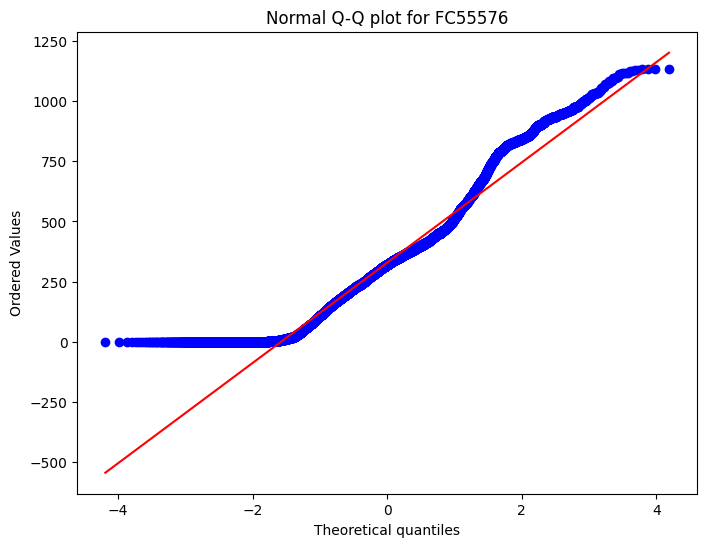

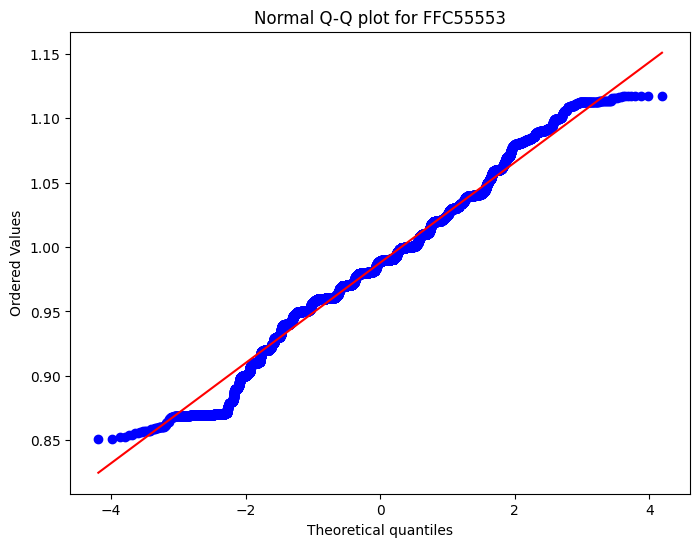

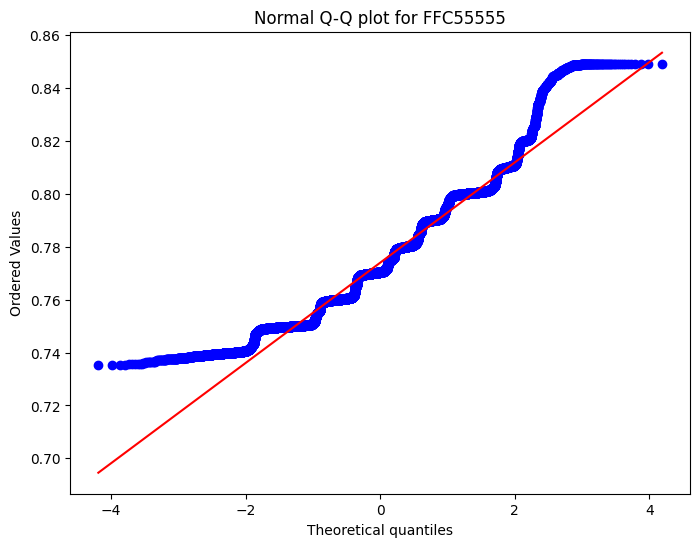

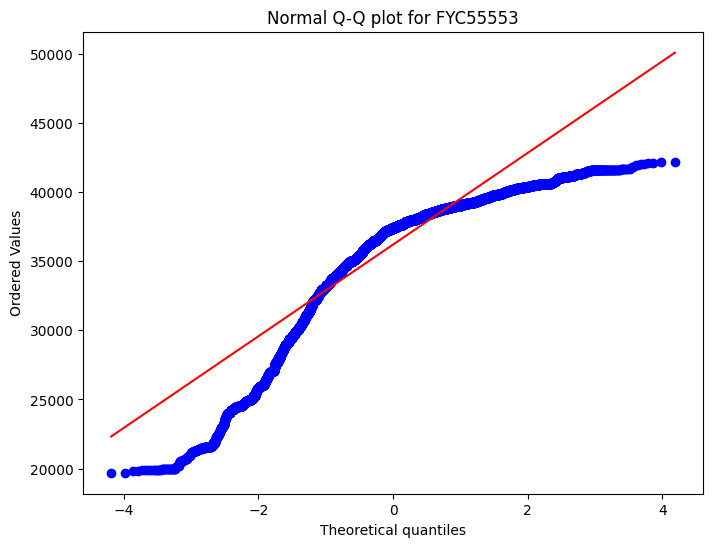

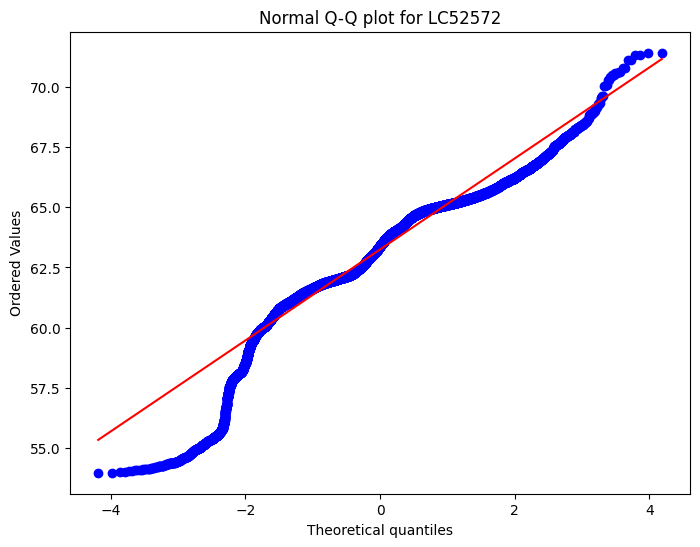

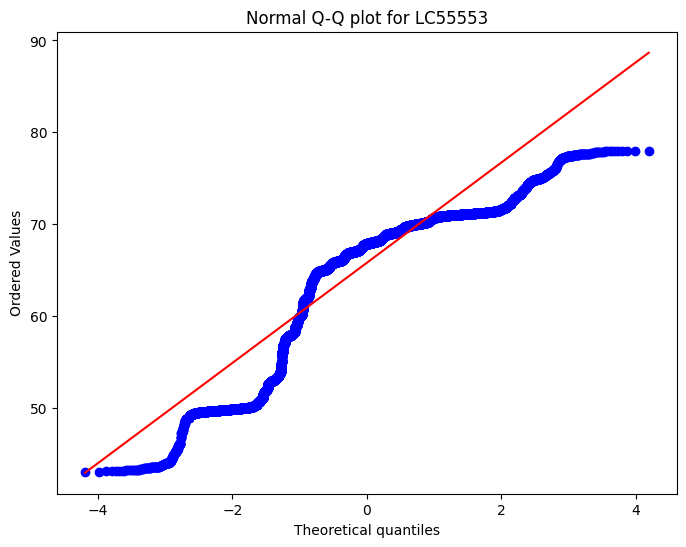

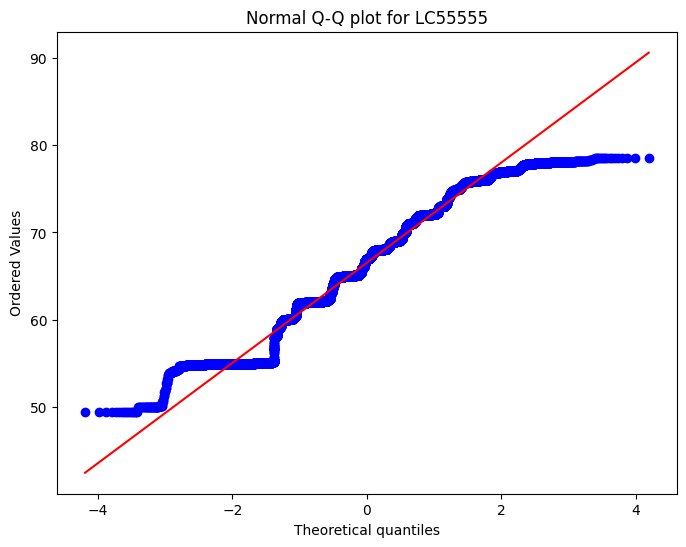

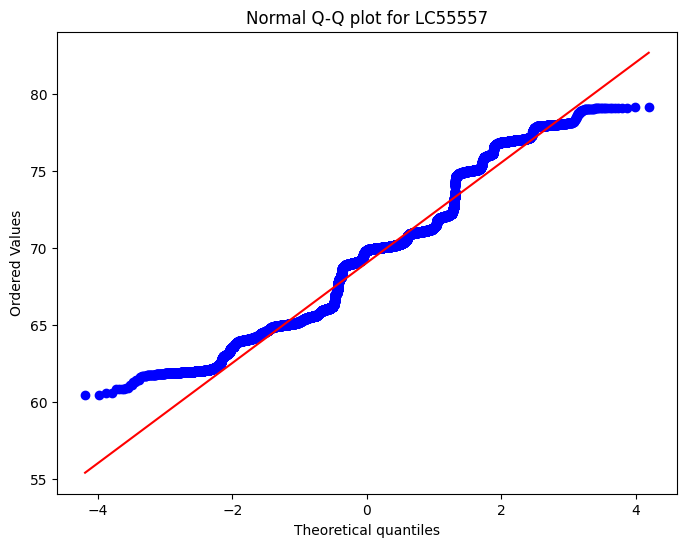

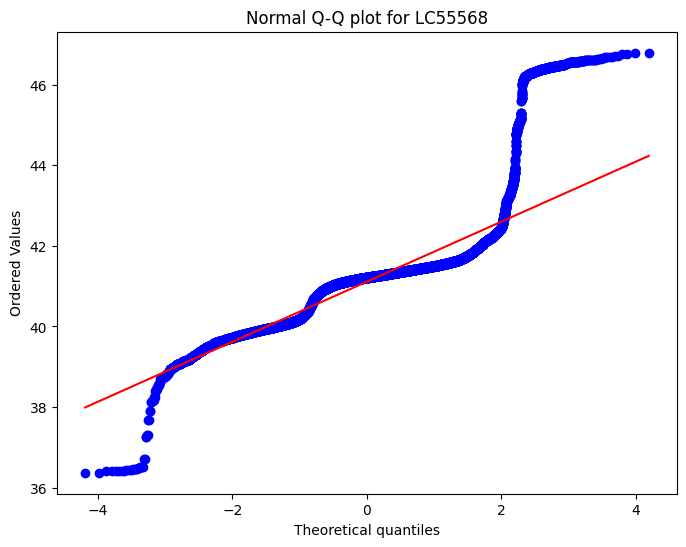

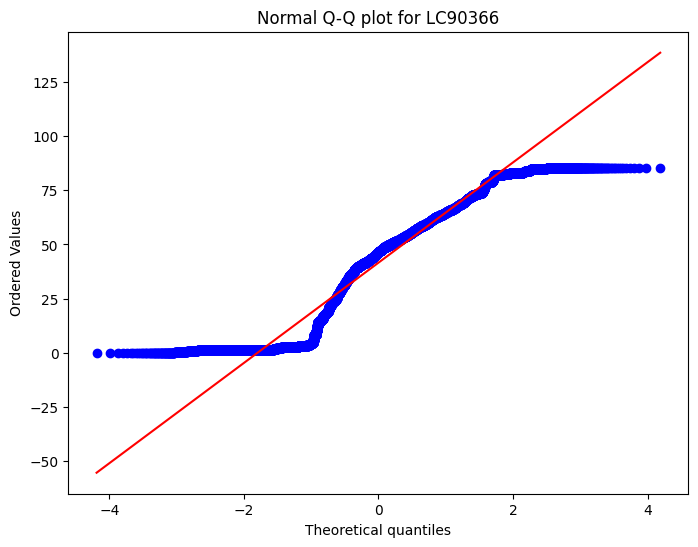

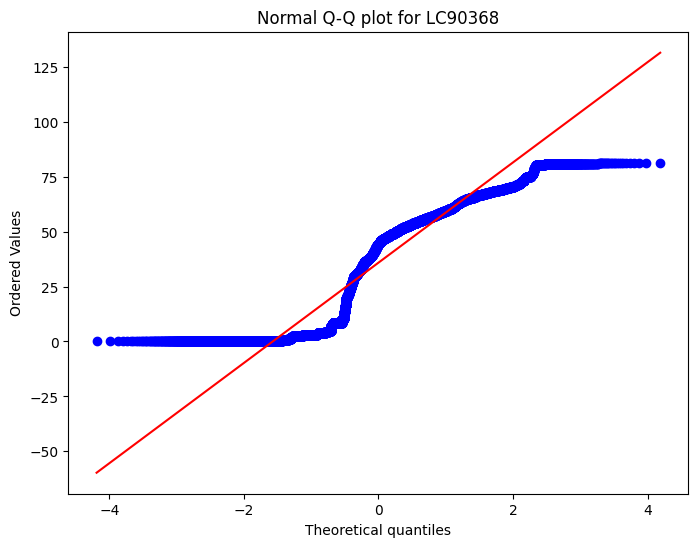

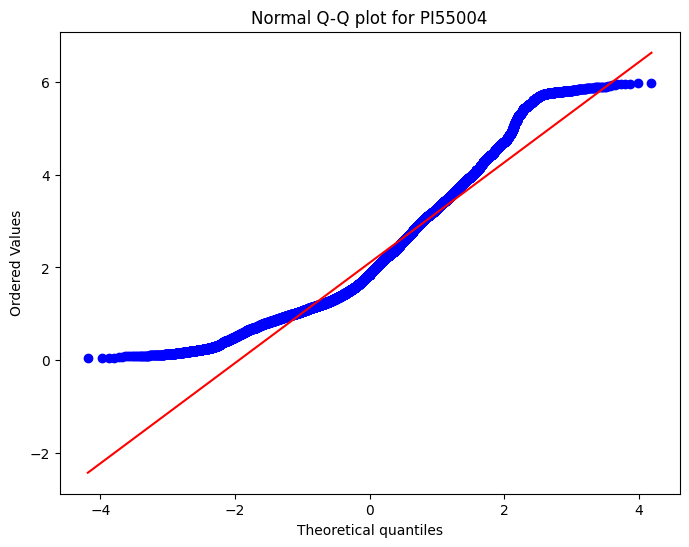

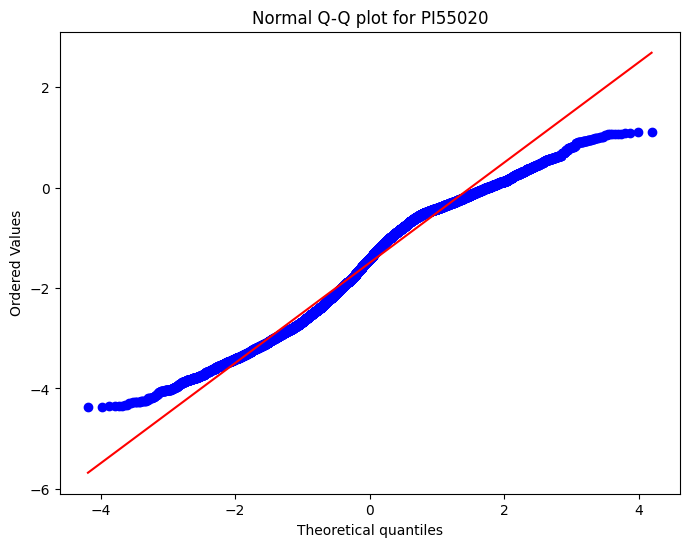

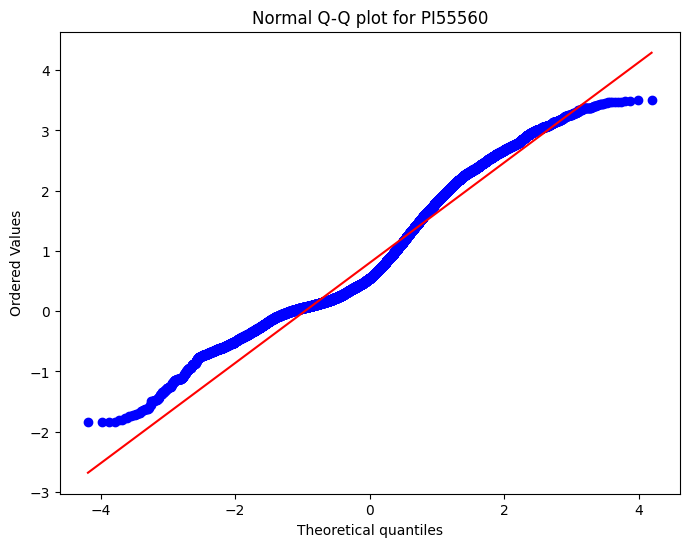

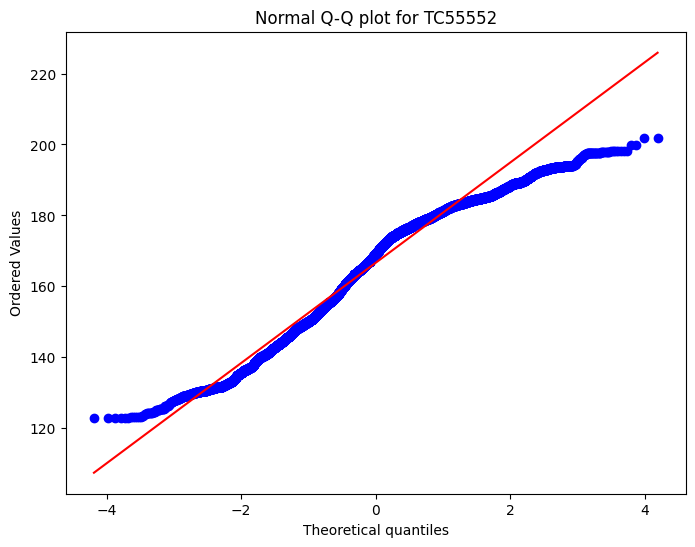

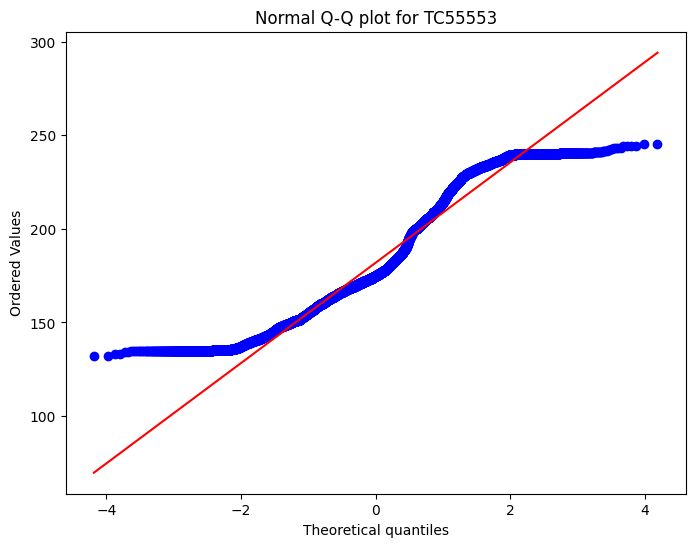

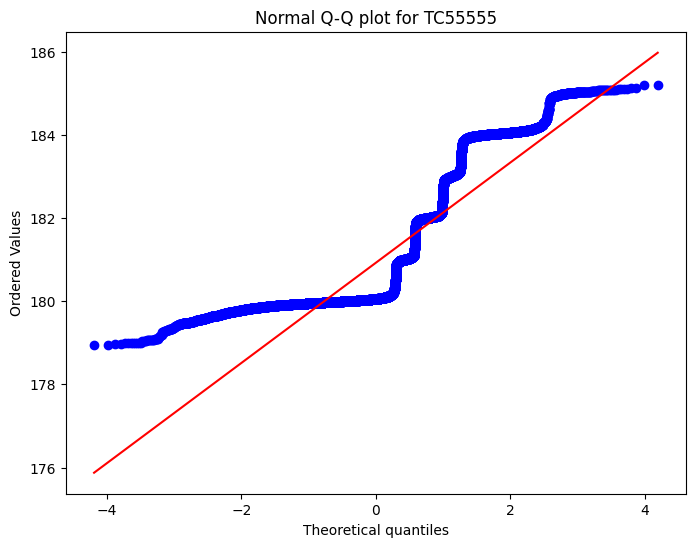

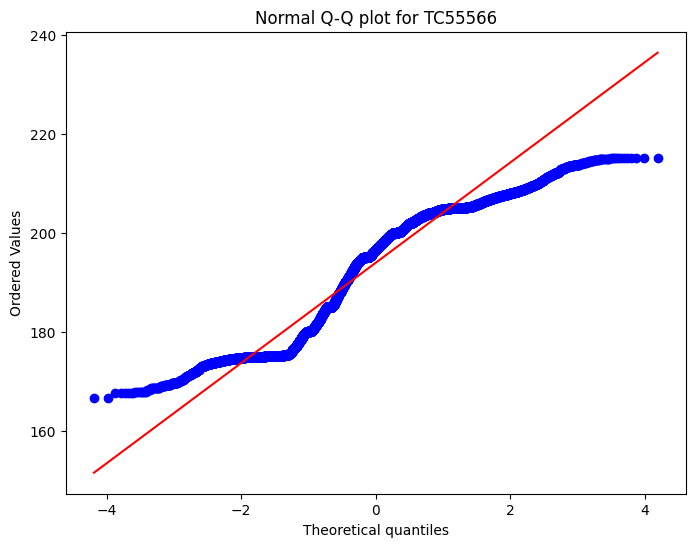

In [35]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Loop through each column except 'Date'
for col in df_All.columns:
    if col != 'Date':
        plt.figure(figsize=(8, 6))
        stats.probplot(df_All[col], dist="norm", plot=plt)
        plt.title(f"Normal Q-Q plot for {col}")
        plt.show()


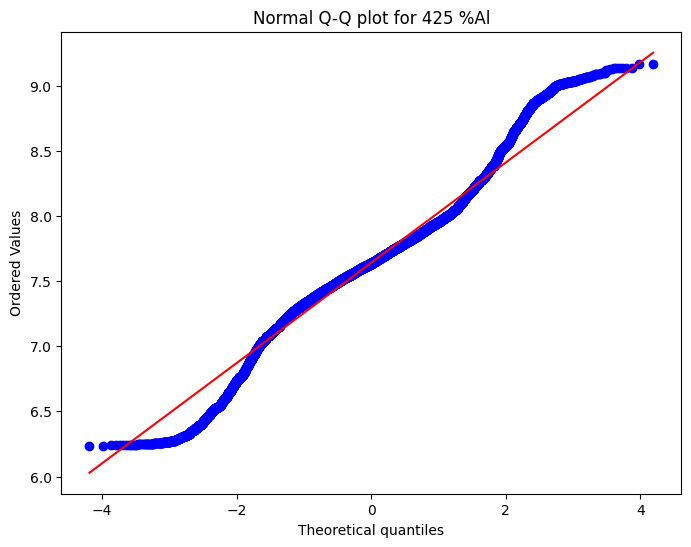

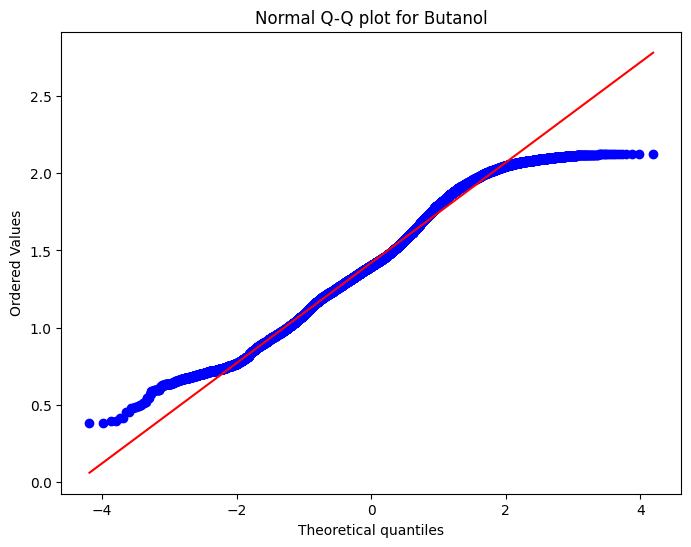

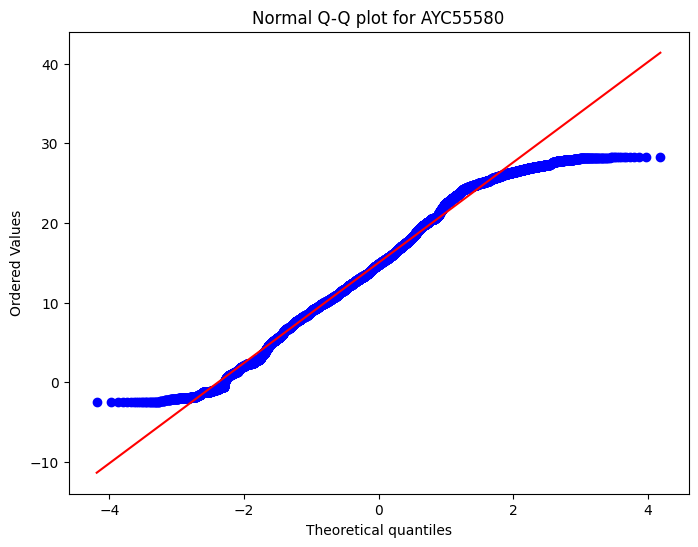

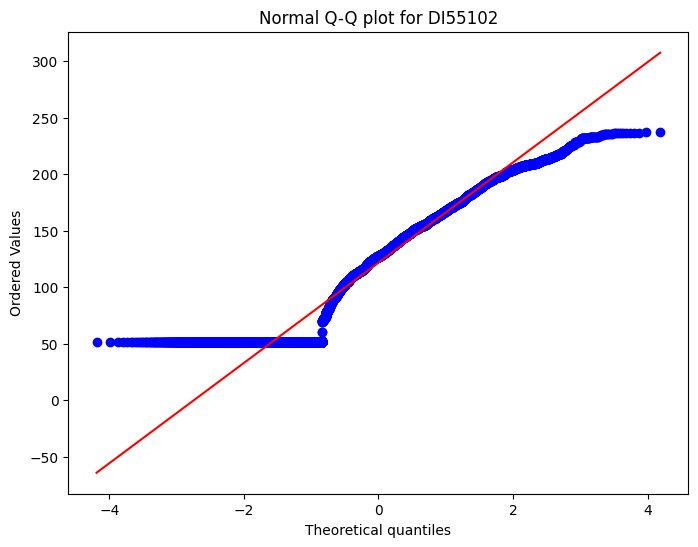

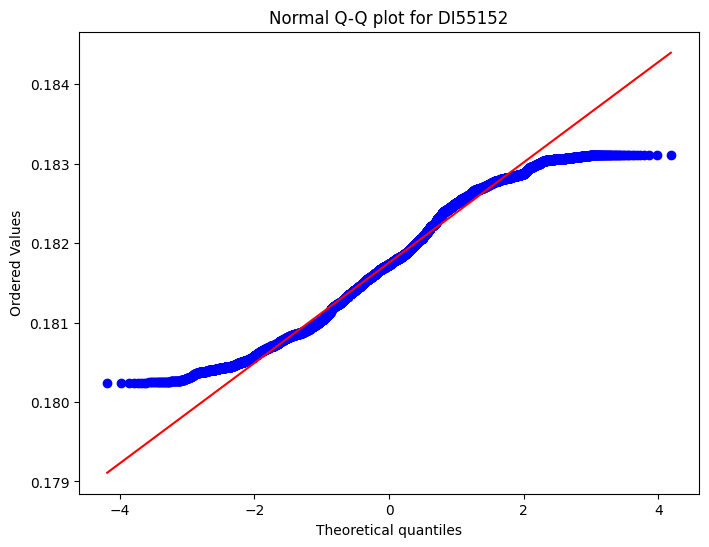

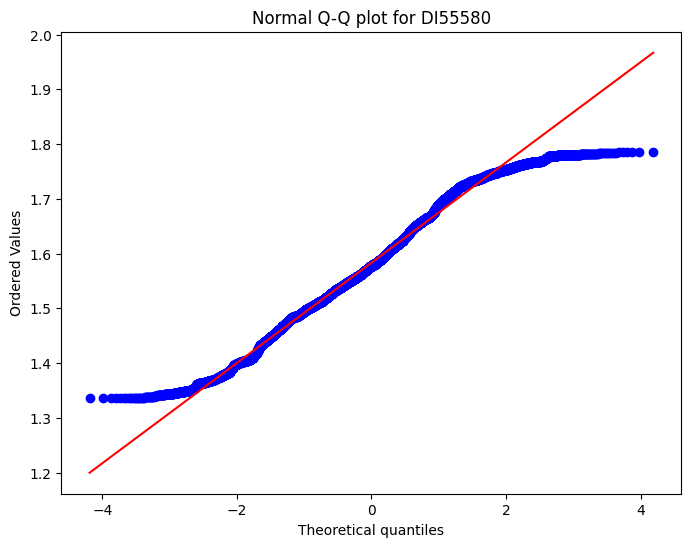

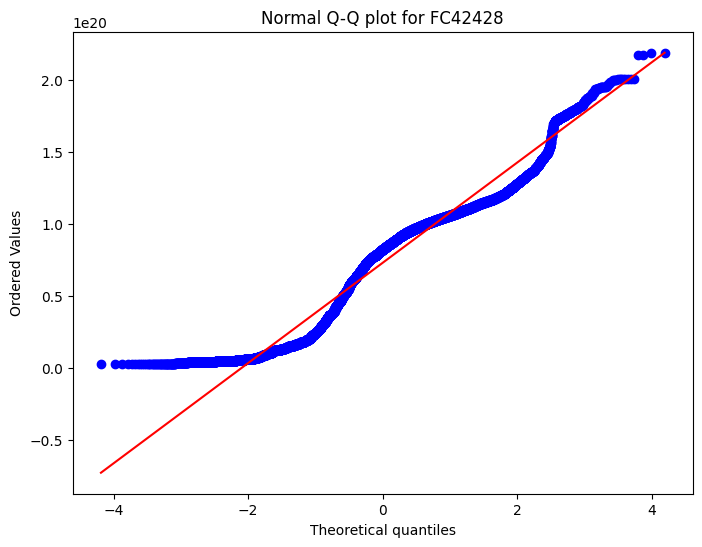

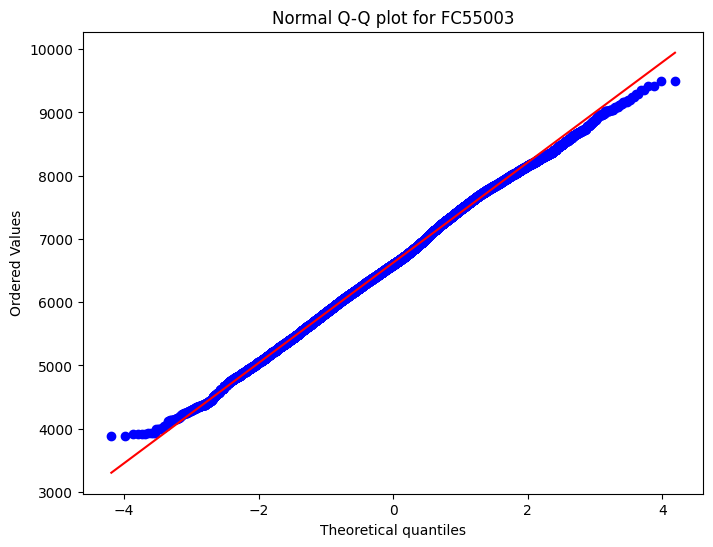

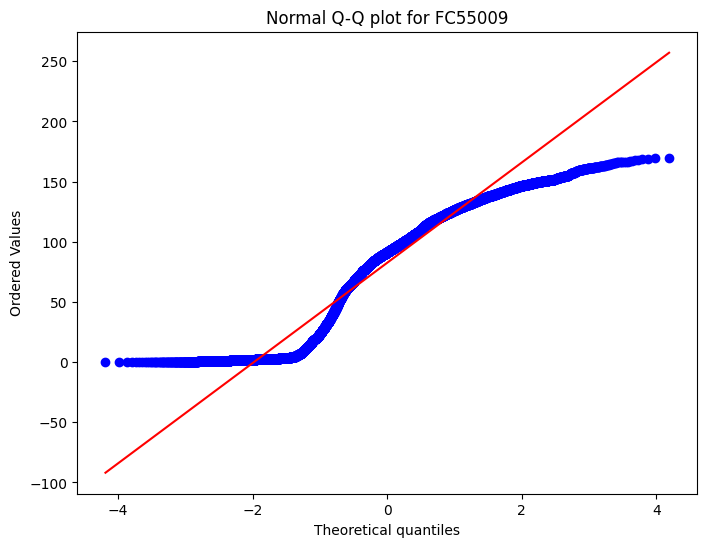

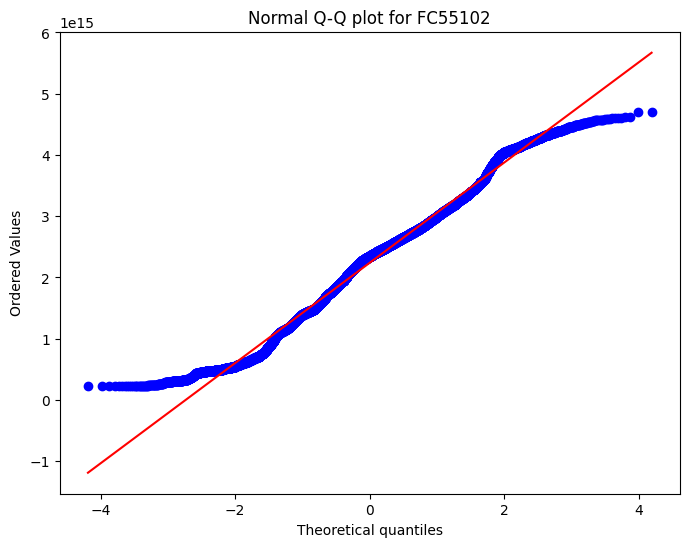

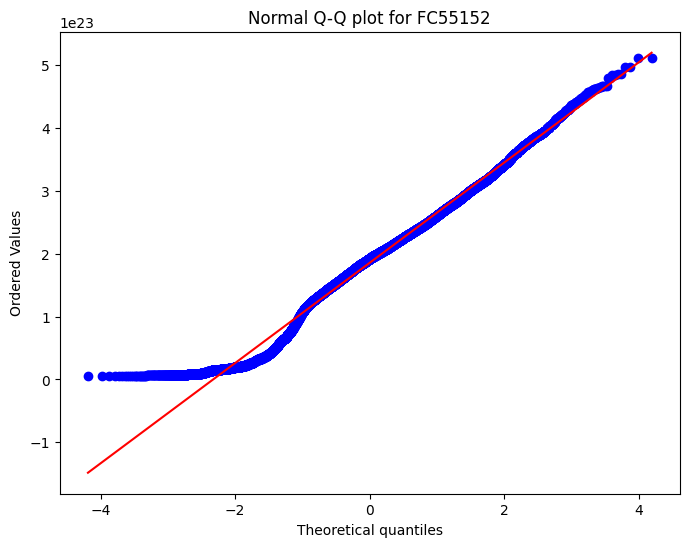

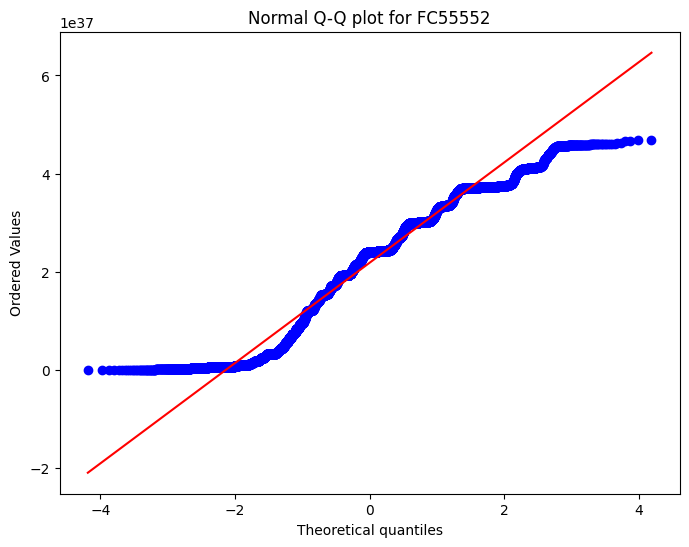

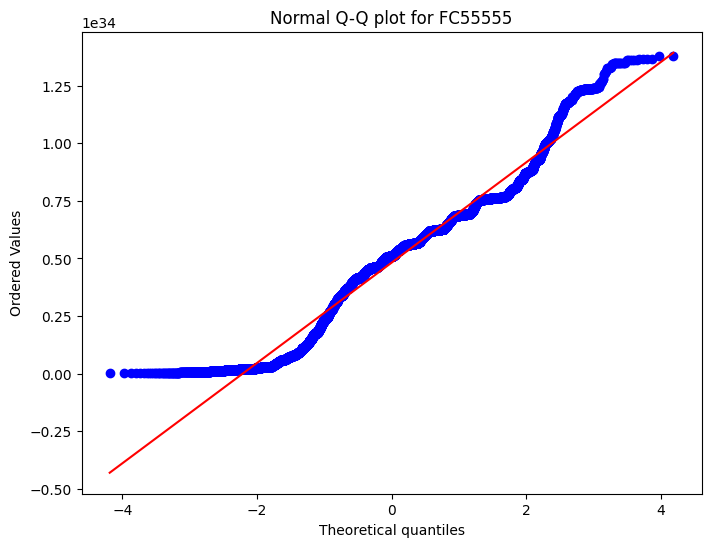

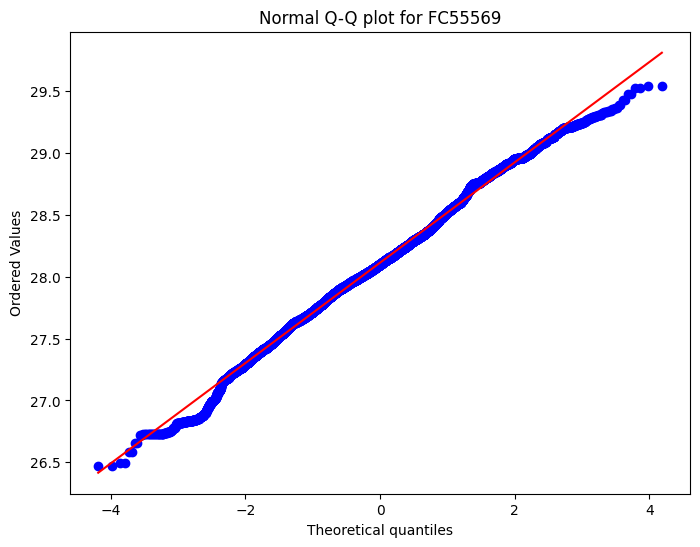

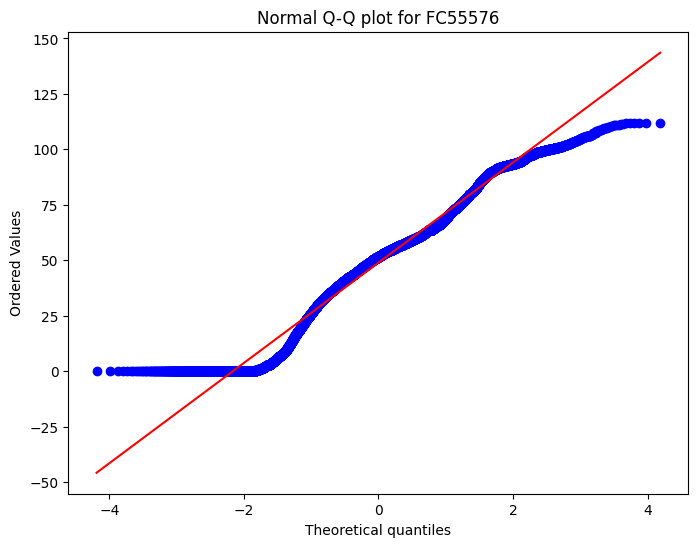

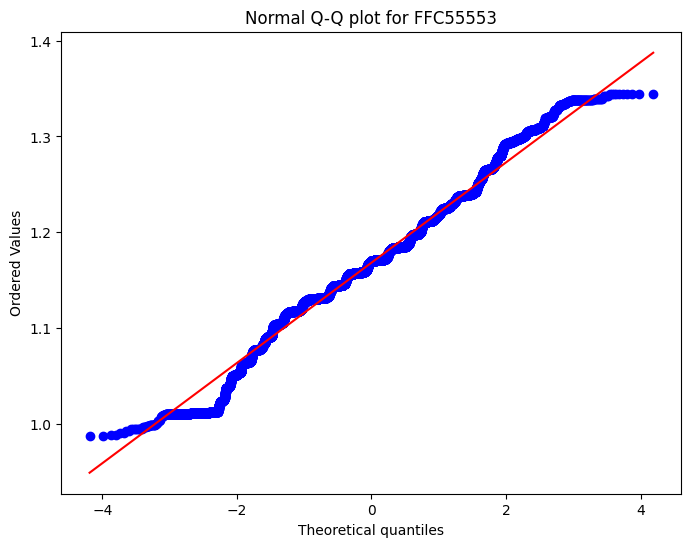

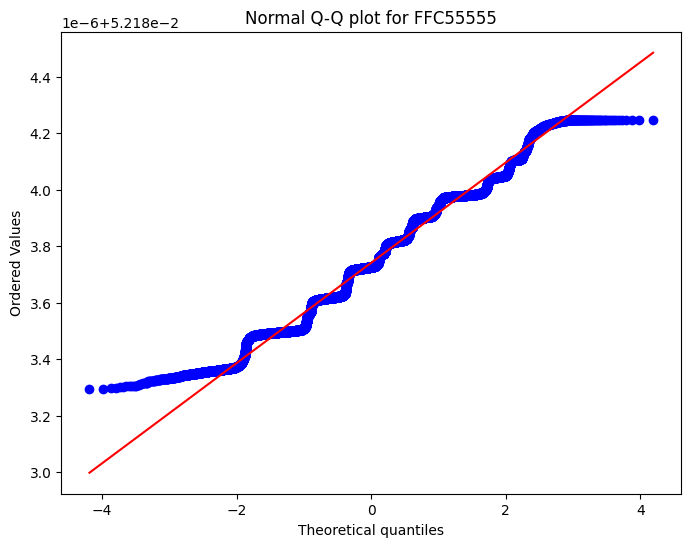

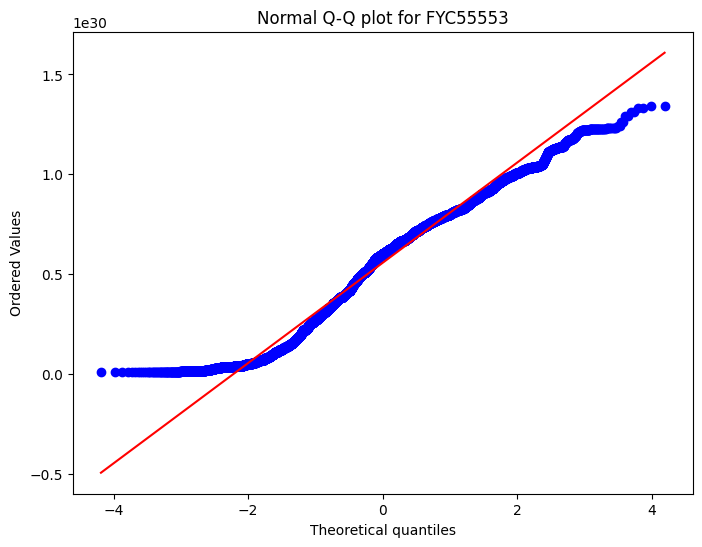

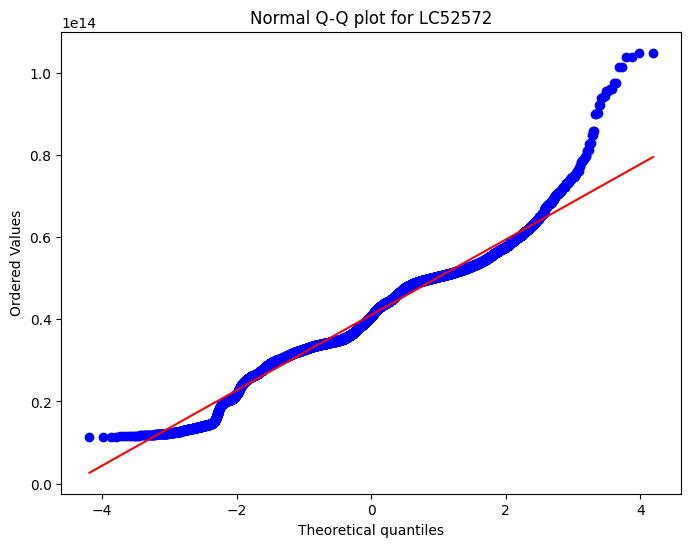

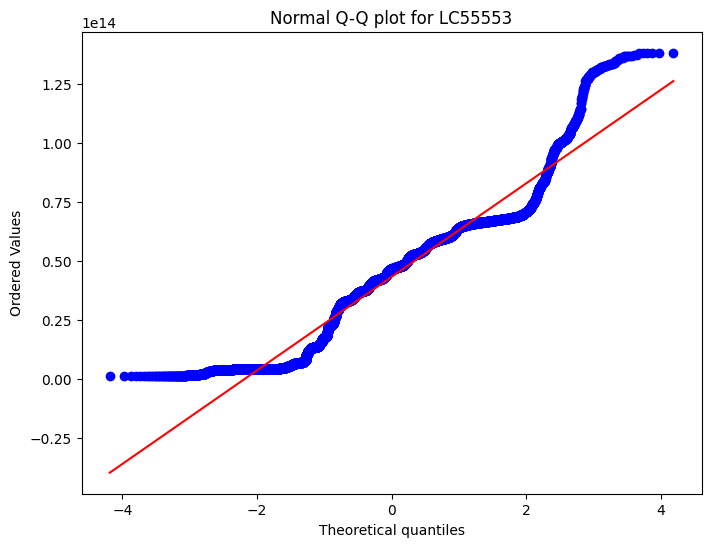

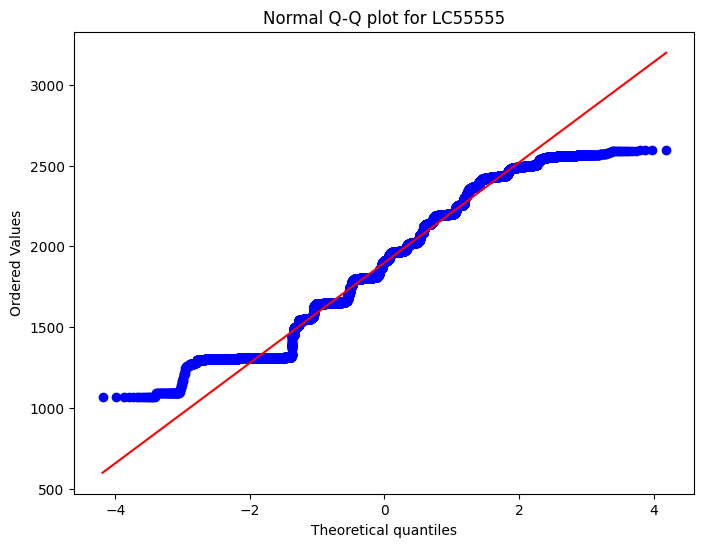

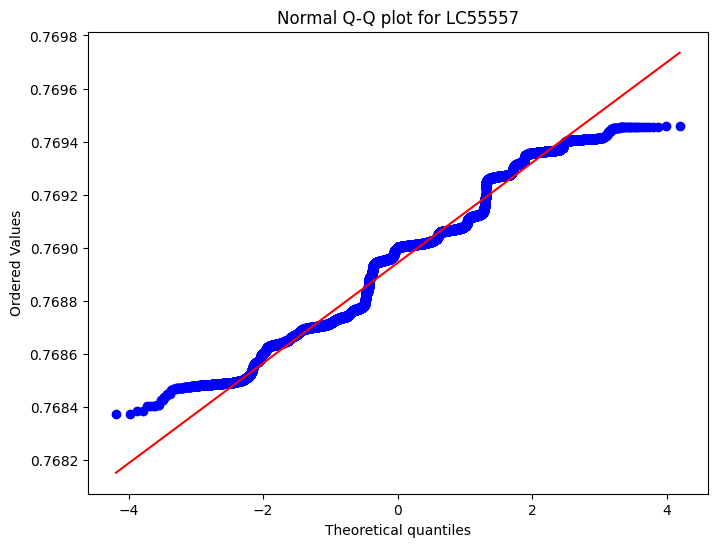

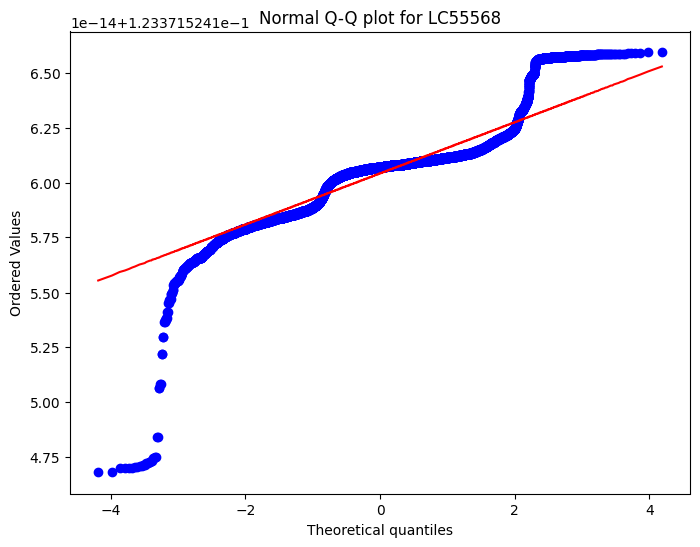

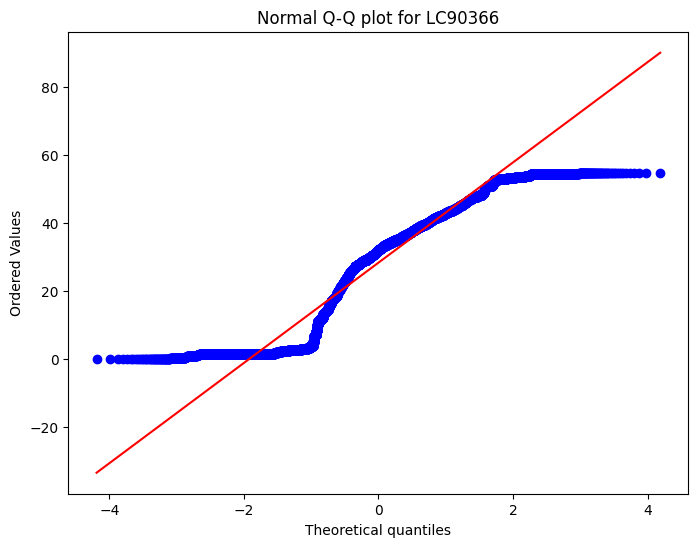

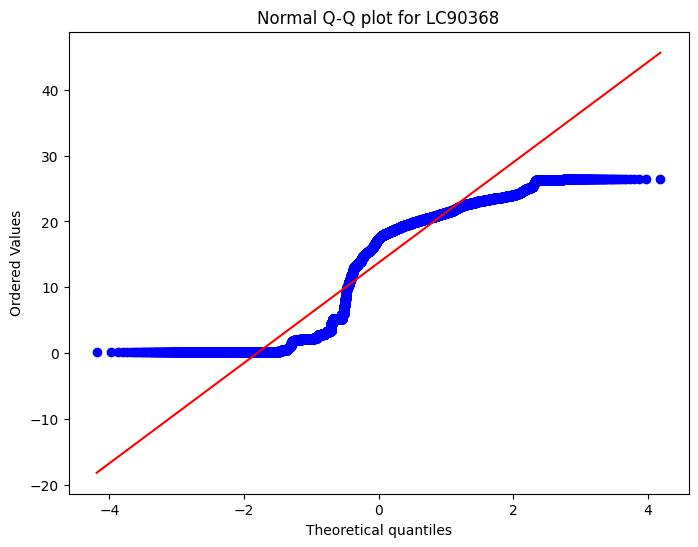

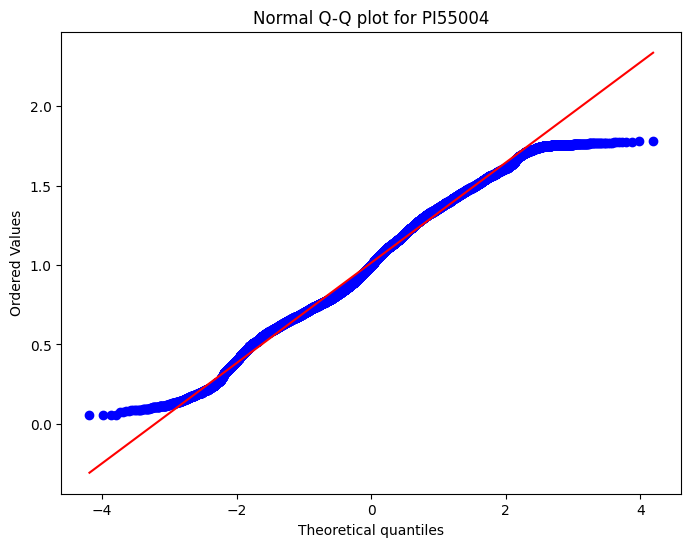

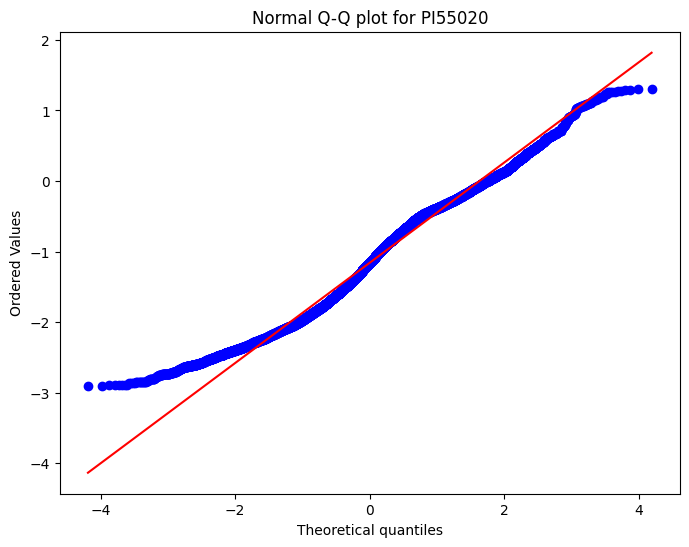

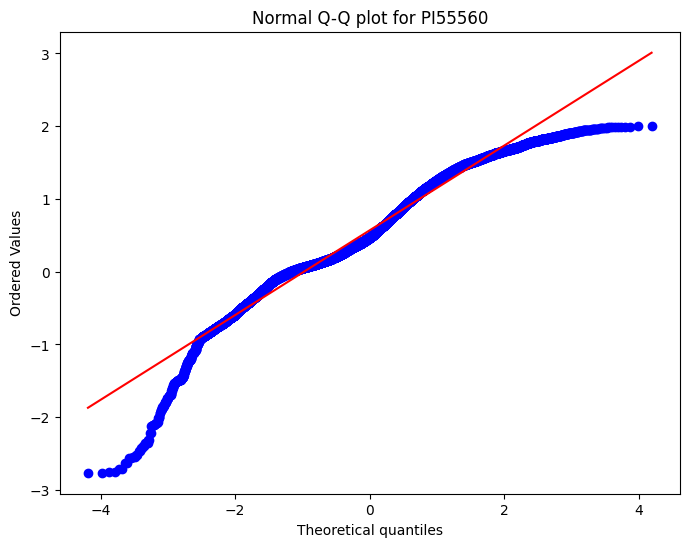

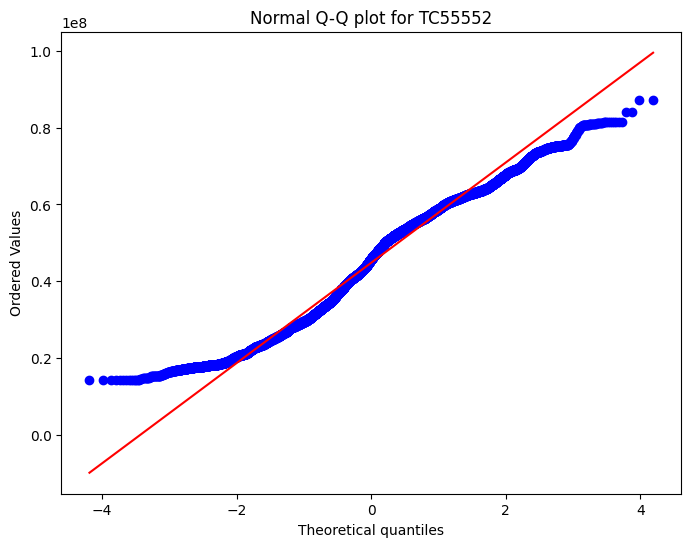

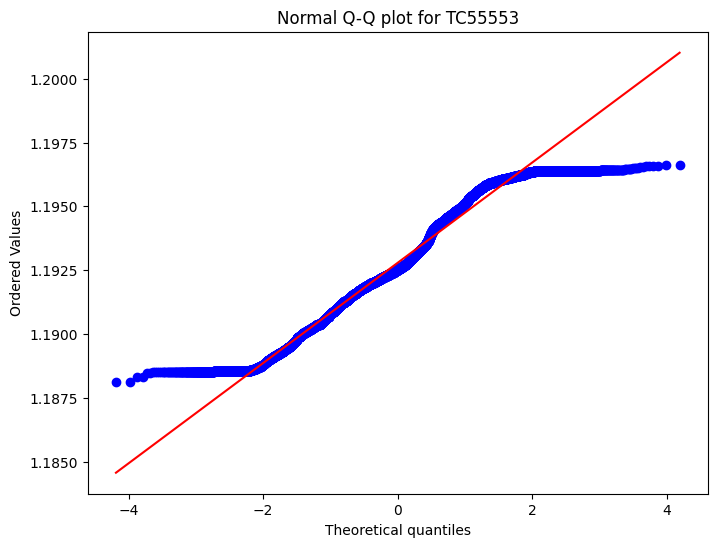

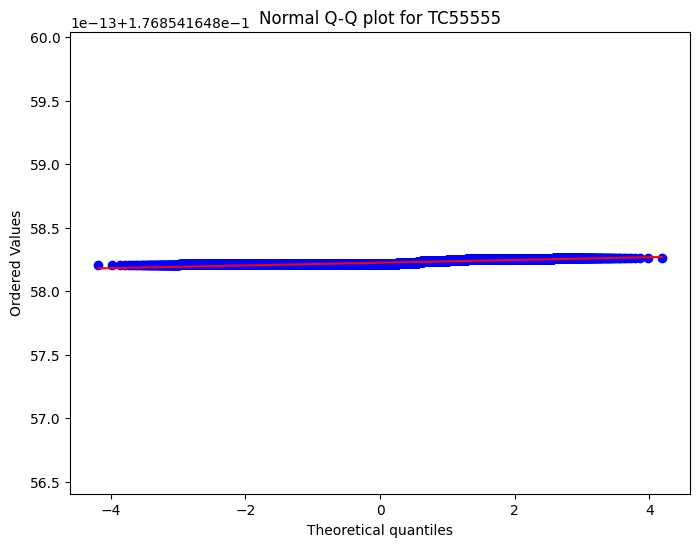

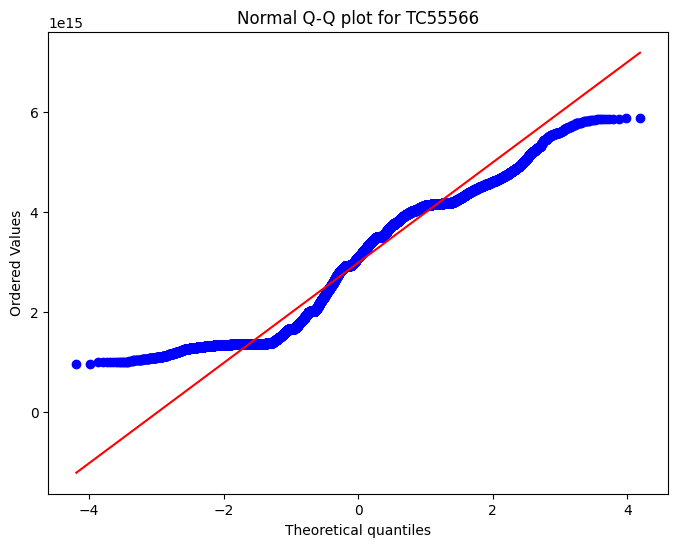

In [36]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Loop through each column except 'Date'
for col in df_yeojohnson.columns:
    if col != 'Date':
        plt.figure(figsize=(8, 6))
        stats.probplot(df_yeojohnson[col], dist="norm", plot=plt)
        plt.title(f"Normal Q-Q plot for {col}")
        plt.show()
